# Introduction to Machine Learning

In this tutorial we are going to start working with some basic machine learning models. We will be using **TensorFlow**, a software library designed to train and use neural networks efficiently.

We will train three models:

1. A simple linear regression model. Naturally, there are easier ways to perform linear regression, and you would not actually use this type of model in a realistic scenario. However, it is useful to understand the basics of how neural networks work.
2. A dense neural network for image classification. We will be using the **Fashion-MNIST** dataset, which is a simple way to get started.
3. A convolutional neural network (CNN) for image classification. CNNs are powerful models for image processing tasks, and therefore it is useful to get acquainted with them.

> **Tip**: if you are running this in Google Colab, you can enable GPU computation by clicking on **Runtime > Change runtime type** and selecting **GPU** under **Hardware accelerator**. This will significantly speed up training of neural networks.

If you are running this outside the live session, please refer to the slides or the recording for more detailed explanations about these exercises. 

## Linear regression

Neural networks are typically used to tackle complex problems. However, to understand how they work it is useful to consider a simple problem: **linear regression**. In linear regression, we assume there is a linear relationship
between an independent or explanatory variable, $x$, and a dependent or response variable, $y$. This can be expressed mathematically as:

$$y = wx + b$$

where $w$ is the slope of the line, called **weight**, and $b$ is the intercept, called **bias**.

In [4]:
# TensorFlow is a library designed to perform training and inference
# of neural networks.
import tensorflow as tf
# Matplotlib is a plotting library. We'll use it to create some plots below.
import matplotlib.pyplot as plt

Let's define some simple dummy data. Here `x` (the inputs) and `y` (the outputs) are related by the linear function $y = 2x - 4$.

In [ ]:
x = tf.constant([0, 1, 2, 3, 4, 5], dtype=tf.float32)
y = tf.constant([-4, -2, 0, 2, 4, 6], dtype=tf.float32)

plt.plot(x, y, 'o')
plt.show()

Now let's create the most basic ML model possible and see if it can figure out the relationship between these numbers.

In [37]:
# The weights of a neural network are generally initialized randomly. In order
# to ensure that we get reproducible results, we can set the random seed. The
# choice of the seed is arbitrary.
tf.random.set_seed(1234)

# Create a linear model (y = wx + b).
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, input_shape=[1])
])

# Configure the model for training.
model.compile(optimizer='sgd', loss='mean_squared_error')

# Train the model.
history = model.fit(x, y, epochs=500, verbose=0)

Training should complete quickly. Once done, we need to assess the results. If the model is learning correctly, we should see the loss becoming lower over time. The `history` object returned by `model.fit` holds information about the loss for each epoch. Let's use it to plot the loss over time.

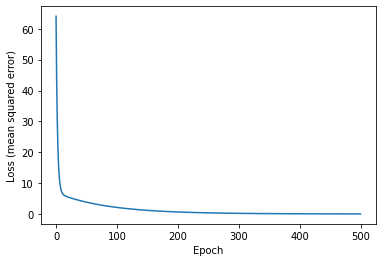

In [6]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss (mean squared error)')
plt.show()

We can access the model's parameters via its `weights` attribute:

In [7]:
for w in model.weights:
  print(w)

<tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[1.9322925]], dtype=float32)>
<tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([-3.7597415], dtype=float32)>


As you can see, the model we created has two parameters, called `kernel` and `bias`. The kernel is the `w` multiplying `x` in our linear function, while the bias is the additive term `b`. If everything went well, the parameters should have values close to 2 and -4, respectively. This is what we were expecting! 

# Image classification using dense neural networks

We will now begin to work with a more complex problem: image classification.

In this example, we will be using the Fashion MNIST dataset. This is an alternative to the classic MNIST (Modified National Institute of Standards and Technology) dataset of hand-written digits, which is widely used in machine learning.

The dataset consists of low-resolution, grayscale images of fashion items, such as T-shirts and dresses, and it comes already split into a training set and a test set. It also has labels for each example, which indicate the class of each
item (e.g., T-shirt).

The task is to train a model that, given an image, can predict the class of the contained item.

The Fashion MNIST dataset is available in Keras and can be loaded as follows: 

In [8]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


`fashion_mnist.load_data()` returns 4 arrays: `train_images`, `train_labels`, `test_images` and `test_labels`. `train_images` and `train_labels` are the training set. We will use these to train our model.

In [9]:
print("shape of train_images: ", train_images.shape)
print("shape of train_labels: ", train_labels.shape)

shape of train_images:  (60000, 28, 28)
shape of train_labels:  (60000,)


As you can see, the training dataset consists of 60,000 images, each of which has size 28 x 28, and the corresponding labels.

`test_images` and `test_labels` form the test set. We will use those to
evaluate the trained model.

In [10]:
print("shape of test_images: ", test_images.shape)
print("shape of test_labels: ", test_labels.shape)

shape of test_images:  (10000, 28, 28)
shape of test_labels:  (10000,)


The test set looks similar to the training set, except it has 10,000 examples.

The labels are integers between 0 and 9, where 0 is the first class, 1 is the
second class, and so on. There are 10 classes in total.

In [11]:
print(train_labels[:10])

[9 0 0 ... 3 0 5]


The corresponding names for each class are as follows:

In [12]:
class_names = ['T-shirt/top',
               'trouser',
               'pullover',
               'dress',
               'coat',
               'sandal',
               'shirt',
               'sneaker',
               'bag',
               'ankle boot']

Let's explore the first few training examples:

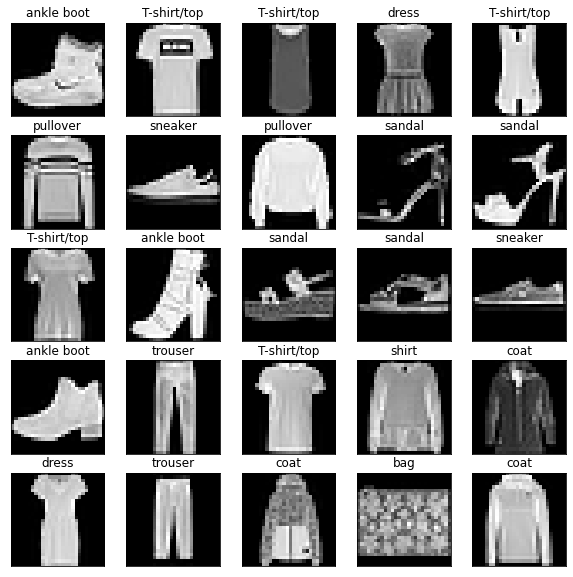

In [13]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(25):
  row, col = i // 5, i % 5
  image = train_images[i]
  label = class_names[train_labels[i]]
  ax[row, col].imshow(train_images[i], cmap="gray")
  ax[row, col].set_xticks([])
  ax[row, col].set_yticks([])
  ax[row, col].set_title(label)
plt.show()

As you can see, each example is a grayscale image with pixel intensities between
0 and 255. Each image shows a fashion item of a certain class.

We need to do some basic preprocessing before we can feed these data to our model. First, neural networks work better when their input and output values are small, so we usually rescale images to the range [0, 1].

In [14]:
train_images = train_images.astype("float32") / 255
test_images = test_images.astype("float32") / 255

Additionally, remember that, in multiclass classification, we typically represent labels using one-hot encoding. We can use [`tf.one_hot`](https://www.tensorflow.org/api_docs/python/tf/one_hot) to create one-hot vectors from integer labels.

In [15]:
train_labels_onehot = tf.one_hot(train_labels, depth=10)
test_labels_onehot = tf.one_hot(test_labels, depth=10)

Here are a few examples of how this transformation works:

In [16]:
for i in range(5):
  print(f"integer to one-hot ({i}):", train_labels[i], "-->", train_labels_onehot[i].numpy())

integer to one-hot (0): 9 --> [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
integer to one-hot (1): 0 --> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
integer to one-hot (2): 0 --> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
integer to one-hot (3): 3 --> [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
integer to one-hot (4): 0 --> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


> **Tip!** Keras also lets you input integer labels directly. It will still do the above transformation, but it will be done automatically, behind the scenes. Have a look at the [sparse categorical cross-entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) loss function to learn more!

Great! We are ready to create the model.

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               100480    
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


The [`summary`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary) method is a useful utility to get basic information about the model at a glance. The model we have created is made up of 3 layers. Remember that a layer is the basic building block used to create neural networks. Many layers have parameters that are learned during training.

* The [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) layer takes an input image of shape `[28, 28]` and flattens it into a 1D vector of size 28 x 28 = 784. This layer does not have any parameters.
* The first [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer takes this flattened image and returns a feature vector of size 128 (the number of units). Remember that, in dense layers, every input element is connected to every unit through a learned weight, so we have 784 x 128 = 100,352 weights. Additionally, each unit has a bias, so we have a total of 100,352 + 128 = 100,480 parameters. 
* The second and final `Dense` layer takes the previous feature vector and outputs a new feature vector of size 10, which is the number of classes. To ensure that this output is a probability distribution over the predicted classes, we use the softmax activation.

We need to configure a few more things before we can train our model, using the [`compile`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) method.

In [18]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Here we are specifying three things:

* The **optimizer** is the algorithm that controls how the model's parameters must be updated. Adam is a very popular algorithm and it is an improvement over the classic gradient descent.
* The **loss** is the function that measures how well the model's predictions agree with the ground truth labels. A lower value is better and the training process will attempt to reduce the loss over time. The [categorical cross-entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) loss is commonly used for multiclass classification problems.
* The **metrics** are additional values we might want to keep track of during training. For example, we could look at the accuracy, i.e., the proportion of examples that are classified correctly. Note that metrics only have an informative purpose and do not affect training in any way. Only the loss is used to drive parameter updates.

Great! We are ready to train the model by calling the [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method.

In [19]:
history = model.fit(train_images, train_labels_onehot, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4978 - accuracy: 0.8254
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3704 - accuracy: 0.8673
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3345 - accuracy: 0.8782
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3101 - accuracy: 0.8863
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2931 - accuracy: 0.8912
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2780 - accuracy: 0.8971
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2671 - accuracy: 0.9000
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2556 - accuracy: 0.9051
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2463 - accuracy: 0.9066
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.238

As the training progresses, Keras will display information such as the current epoch and the current values for the loss function and metrics. This information is also returned in the `history` object. Let's use it to plot the training loss and accuracy!

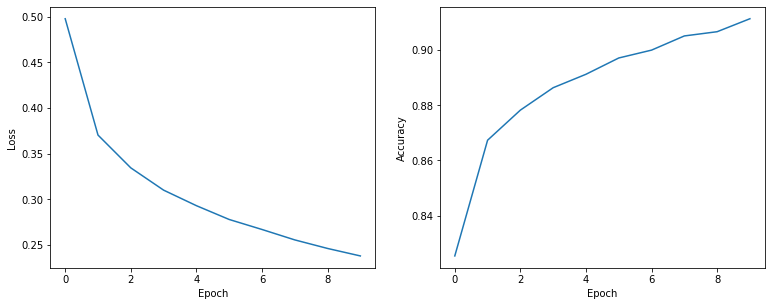

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))
ax[0].plot(history.history['loss'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(history.history['accuracy'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
plt.show()

Finally, let's check the performance on the test set. Remember that being able to extract correct predictions on the training set is, by itself, entirely useless in the real world (we already knew the answers for those!). For a model to be useful, we must show it can generalize to new, previously unseen data.

In [26]:
loss, acc = model.evaluate(test_images, test_labels_onehot)
print(f"The test loss is: {loss}")
print(f"The test accuracy is: {acc}")

313/313 [==============================] - 1s 3ms/step - loss: 0.3315 - accuracy: 0.8831
The test loss is: 0.3315463066101074
The test accuracy is: 0.8830999732017517


# Image classification using convolutional neural networks

Convolutional neural networks are particularly well suited for image processing tasks. Most image processing applications of deep learning use convolutions. We will now train a model 

In [38]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax"),
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1600)              0         
                                                                 
 dense_6 (Dense)             (None, 10)               

This model has different layer types:

* An [`Input`](https://www.tensorflow.org/api_docs/python/tf/keras/Input) layer. This is sometimes used as a placeholder for the actual inputs. Note that the input shape is `(28, 28, 1)`, i.e., (height, width, channels).
* [`Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) applies a 2-dimensional convolution. In convolutional layers, we must specify the number of filters and their size. We can also include an activation function. Note that convolutional layers have one output channel per filter.
* [`MaxPooling2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPooling2D) applies 2-dimensional max-pooling along the spatial dimensions. Note how the output dimensions are half those of the inputs.
* [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) takes the high-level features of size `(5, 5, 32)` and flattens them into a 1D vector of size `(1600,)`.
* The final [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer predicts the class probabilities based on the intermediate feature vector.

As before, we need to configure a few extra things before we can begin to train.

In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

Note that, in this case, we specified the optimizer as [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) instead of `'adam'`. This syntax is a bit more verbose, but it has the advantage that it lets us specify the learning rate.

It is useful to know that `model.fit` accepts a `validation_data` argument, which we can use to pass a validation set (or the test set, in this case). When doing this, Keras will also keep track of the loss and metrics over time for this dataset. Note that this has an informative purpose only and does not affect training in any way.

In [41]:
history = model.fit(train_images, train_labels_onehot,
                    epochs=10,
                    validation_data=(test_images, test_labels_onehot))

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4788 - accuracy: 0.8281 - val_loss: 0.3732 - val_accuracy: 0.8677
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3322 - accuracy: 0.8819 - val_loss: 0.3374 - val_accuracy: 0.8810
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2879 - accuracy: 0.8955 - val_loss: 0.2883 - val_accuracy: 0.8985
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2614 - accuracy: 0.9063 - val_loss: 0.2852 - val_accuracy: 0.8962
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2404 - accuracy: 0.9133 - val_loss: 0.2735 - val_accuracy: 0.8987
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2243 - accuracy: 0.9181 - val_loss: 0.2762 - val_accuracy: 0.8990
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2091 - accuracy: 0.9240 - val_loss: 0.2614 - val_accuracy:

Let's plot the results.

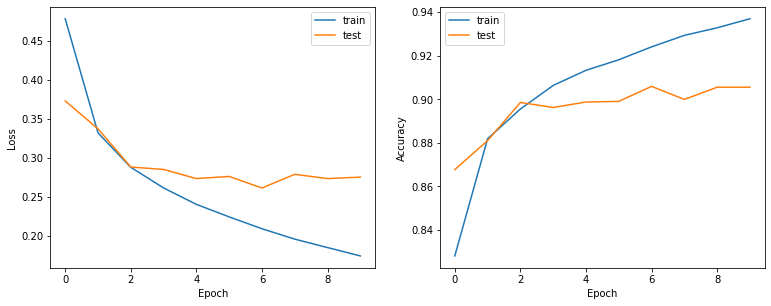

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))
ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='train')
ax[1].plot(history.history['val_accuracy'], label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

In [ ]:
loss, acc = model.evaluate(test_images, test_labels_onehot)
print(f"The test loss is: {loss}")
print(f"The test accuracy is: {acc}")

Great! If everything went well, this model probably outperformed your previous attempt using dense layers. And this is despite the fact that it has significantly less parameters: 34,826, down from 101,770!

# Conclusion
In this tutorial, we created 3 machine learning models using TensorFlow. First, we trained the simplest possible model to perform linear regression. Secondly, we created a dense neural network to classify images of fashion items. Finally, we approached the same problem using convolutional neural networks.

We used the Fashion MNIST dataset, a classic ML dataset which is clean, labelled, split into training/test and ready to load with a single line of code. In the real world, of course, datasets do not usually come in such a nice format. In the next sessions, we will learn more about handling medical imaging data.